# Model Deep Learning (PyTorch dan TensorFlow)

Notebook ini berisi implementasi model deep learning menggunakan PyTorch dan TensorFlow, serta perbandingan berbagai metrik evaluasi.

## 1. Import Library

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import requests
from io import StringIO

# Import library PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import library TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Set seed untuk reproduksibilitas
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

## 2. Load dan Preprocessing Data

In [2]:
# Mengunduh dataset dari GitHub
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/income.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Data:")
print(df.head())
print("\nStatistik Deskriptif:")
print(df.describe())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None

Sampel Data:
   age         workclass  fnlwgt  education  education-

In [3]:
# Cek nilai yang hilang
print("\nJumlah nilai yang hilang pada setiap kolom:")
print(df.isnull().sum())

# Periksa distribusi target (income)
print("\nDistribusi Target (income):")
print(df['income'].value_counts())
print(df['income'].value_counts(normalize=True))


Jumlah nilai yang hilang pada setiap kolom:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

Distribusi Target (income):
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64
income
<=50K     0.506122
<=50K.    0.254596
>50K      0.160538
>50K.     0.078744
Name: proportion, dtype: float64


In [4]:
# Preprocessing Data

# Konversi target ke numerik
le = LabelEncoder()
df['income_encoded'] = le.fit_transform(df['income'])
print("Encoding label untuk target:")
for i, label in enumerate(le.classes_):
    print(f"{label} -> {i}")

# Pisahkan fitur dan target
# Untuk fitur, kita menggunakan semua kolom kecuali 'income' dan 'income_encoded'
X = df.drop(['income', 'income_encoded'], axis=1)
y = df['income_encoded']

# Handle categorical features
X = pd.get_dummies(X)

# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Encoding label untuk target:
<=50K -> 0
<=50K. -> 1
>50K -> 2
>50K. -> 3


## 3. Membangun Model PyTorch

In [5]:
class DeepNetworkPyTorch(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_rate=0.2):
        super(DeepNetworkPyTorch, self).__init__()
        layers = []
        prev_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# Persiapan data PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values)

# Dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Definisikan model
input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]  # Tiga hidden layers
num_classes = len(np.unique(y_train))
model_pytorch = DeepNetworkPyTorch(input_dim, hidden_dims, num_classes)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

In [7]:
# Fungsi untuk melatih model PyTorch
def train_pytorch_model(model, train_loader, criterion, optimizer, num_epochs=50):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass dan optimisasi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses

# Melatih model PyTorch
print("Training PyTorch Model...")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

Training PyTorch Model...
Epoch [10/50], Loss: 0.8964
Epoch [20/50], Loss: 0.8792
Epoch [30/50], Loss: 0.8705
Epoch [40/50], Loss: 0.8603
Epoch [50/50], Loss: 0.8565


In [8]:
# Evaluasi model PyTorch
model_pytorch.eval()
with torch.no_grad():
    y_pred_raw = model_pytorch(X_test_tensor)
    _, y_pred_pytorch = torch.max(y_pred_raw, 1)
    y_pred_pytorch = y_pred_pytorch.numpy()
    y_pred_proba_pytorch = torch.softmax(y_pred_raw, dim=1).numpy()

## 4. Membangun Model TensorFlow

In [9]:
def create_tensorflow_model(input_dim, hidden_dims, num_classes, dropout_rate=0.2):
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_dims[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for hidden_dim in hidden_dims[1:]:
        model.add(Dense(hidden_dim, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Membuat model TensorFlow
model_tensorflow = create_tensorflow_model(input_dim, hidden_dims, num_classes)
model_tensorflow.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          13,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,420 (95.39 KB)

 Trainable params: 24,420 (95.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Melatih model TensorFlow
print("Training TensorFlow Model...")
history = model_tensorflow.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Training TensorFlow Model...
Epoch 1/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5024 - loss: 1.1205 - val_accuracy: 0.5681 - val_loss: 0.9427
Epoch 2/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5564 - loss: 0.9761 - val_accuracy: 0.5714 - val_loss: 0.9291
Epoch 3/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5601 - loss: 0.9596 - val_accuracy: 0.5793 - val_loss: 0.9214
Epoch 4/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5696 - loss: 0.9493 - val_accuracy: 0.5888 - val_loss: 0.9142
Epoch 5/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5775 - loss: 0.9357 - val_accuracy: 0.5901 - val_loss: 0.9055
Epoch 6/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5830 - loss: 0.9249 - val_accuracy: 0.5924 - val_loss: 0.9022
Epoch 7/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5836 - loss: 0.9182 - val_accuracy: 0.5903 - val_loss: 0.8981
Epoch 8/50
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5834 - lo

In [11]:
# Evaluasi model TensorFlow
y_pred_proba_tensorflow = model_tensorflow.predict(X_test)
y_pred_tensorflow = np.argmax(y_pred_proba_tensorflow, axis=1)

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


## 5. Perbandingan Metrik Evaluasi

In [12]:
# Fungsi untuk menghitung semua metrik evaluasi
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    # 1. Akurasi
    accuracy = accuracy_score(y_true, y_pred)

    # 2. Presisi
    precision = precision_score(y_true, y_pred, average='weighted')

    # 3. Recall
    recall = recall_score(y_true, y_pred, average='weighted')

    # 4. F1-Score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # 5. AUC (untuk binary classification atau one-vs-rest approach)
    n_classes = len(np.unique(y_true))

    # One-hot encoding untuk y_true
    y_true_bin = np.zeros((len(y_true), n_classes))
    for i, val in enumerate(y_true):
        y_true_bin[i, val] = 1

    # Hitung ROC dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Average AUC
    mean_auc = np.mean(list(roc_auc.values()))

    # Classification report
    report = classification_report(y_true, y_pred)

    # Print results
    print(f"\nMetrik Evaluasi untuk {model_name}:")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"AUC (rata-rata): {mean_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': mean_auc,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

In [13]:
# Hitung metrik untuk model PyTorch
pytorch_metrics = calculate_metrics(y_test, y_pred_pytorch, y_pred_proba_pytorch, "PyTorch")

# Hitung metrik untuk model TensorFlow
tensorflow_metrics = calculate_metrics(y_test, y_pred_tensorflow, y_pred_proba_tensorflow, "TensorFlow")


Metrik Evaluasi untuk PyTorch:
Akurasi: 0.5919
Presisi (weighted): 0.5983
Recall (weighted): 0.5919
F1-Score (weighted): 0.5131
AUC (rata-rata): 0.7801

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.92      0.73      4945
           1       0.71      0.11      0.19      2487
           2       0.51      0.60      0.55      1568
           3       0.36      0.04      0.07       769

    accuracy                           0.59      9769
   macro avg       0.55      0.42      0.39      9769
weighted avg       0.60      0.59      0.51      9769


Metrik Evaluasi untuk TensorFlow:
Akurasi: 0.5955
Presisi (weighted): 0.6503
Recall (weighted): 0.5955
F1-Score (weighted): 0.5114
AUC (rata-rata): 0.7807

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.92      0.74      4945
           1       0.85      0.10      0.18      2487
           2       0.50      0.63      0.56  

In [14]:
# Bandingkan metrik dari kedua model dalam bentuk tabel
metrics_df = pd.DataFrame({
    'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'AUC'],
    'PyTorch': [pytorch_metrics['accuracy'], pytorch_metrics['precision'],
               pytorch_metrics['recall'], pytorch_metrics['f1'], pytorch_metrics['auc']],
    'TensorFlow': [tensorflow_metrics['accuracy'], tensorflow_metrics['precision'],
                  tensorflow_metrics['recall'], tensorflow_metrics['f1'], tensorflow_metrics['auc']]
})

print("Perbandingan Metrik Evaluasi:")
print(metrics_df)

Perbandingan Metrik Evaluasi:
     Metrik   PyTorch  TensorFlow
0   Akurasi  0.591872    0.595455
1   Presisi  0.598304    0.650299
2    Recall  0.591872    0.595455
3  F1-Score  0.513091    0.511423
4       AUC  0.780132    0.780667


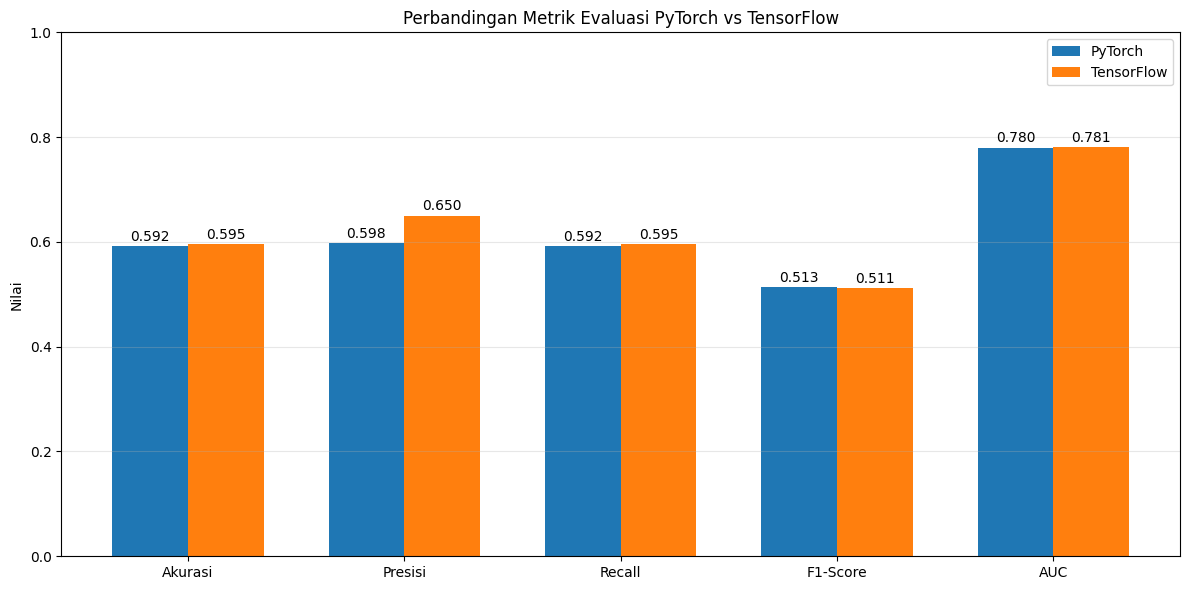

In [15]:
# Visualisasi perbandingan metrik dengan bar plot
plt.figure(figsize=(12, 6))
metrics = metrics_df['Metrik']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, metrics_df['PyTorch'], width, label='PyTorch')
plt.bar(x + width/2, metrics_df['TensorFlow'], width, label='TensorFlow')

plt.ylabel('Nilai')
plt.title('Perbandingan Metrik Evaluasi PyTorch vs TensorFlow')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(metrics_df['PyTorch']):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')

for i, v in enumerate(metrics_df['TensorFlow']):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 6. Visualisasi ROC Curve

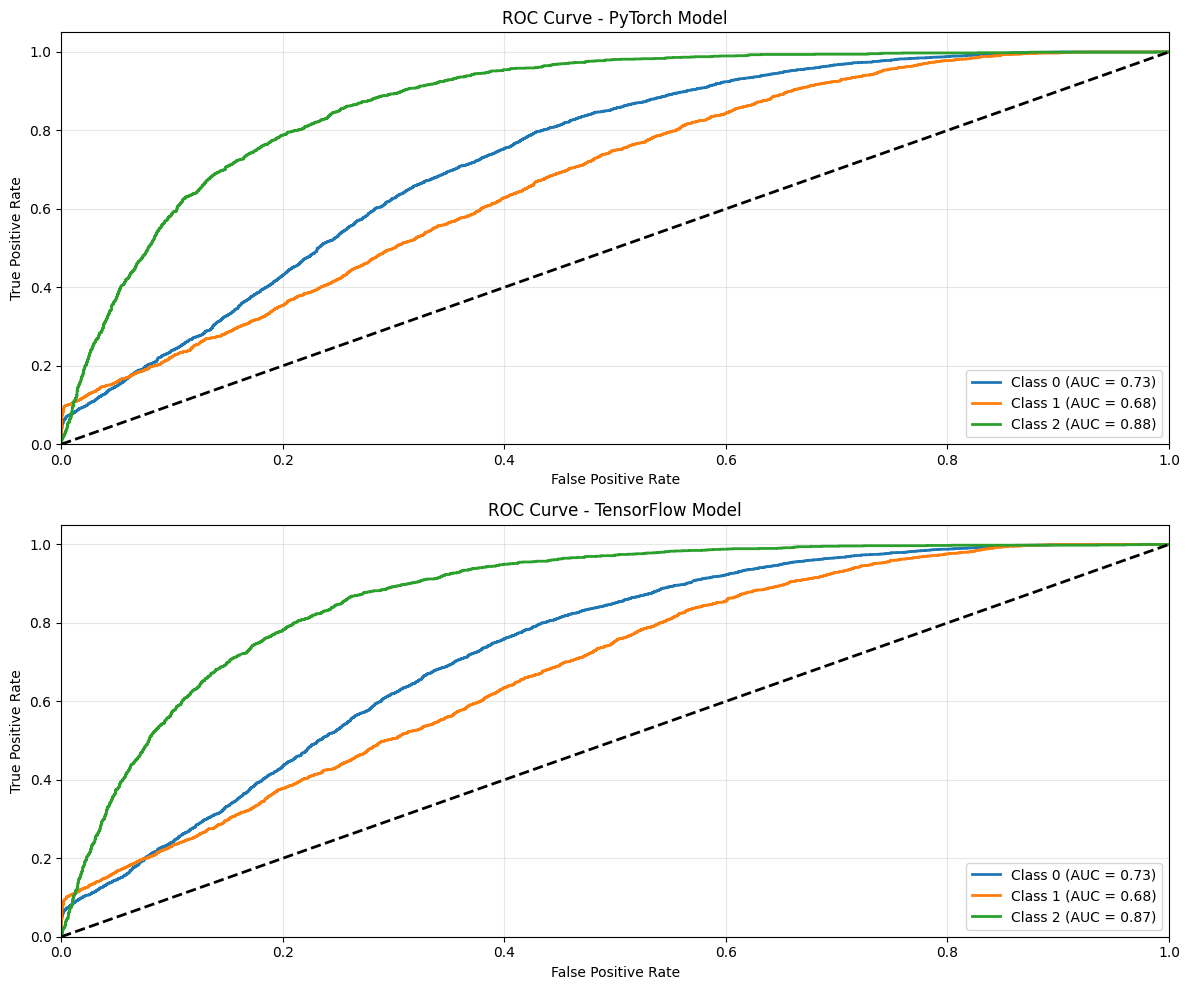

In [16]:
# Plot ROC Curve untuk kedua model
plt.figure(figsize=(12, 10))

# PyTorch ROC Curve (fokus pada kelas 0 dan 1 jika binary classification)
plt.subplot(2, 1, 1)
for i in range(min(3, num_classes)):  # Plot maksimal 3 kelas untuk kejelasan
    plt.plot(pytorch_metrics['fpr'][i], pytorch_metrics['tpr'][i], lw=2,
             label=f'Class {i} (AUC = {pytorch_metrics["roc_auc"][i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# TensorFlow ROC Curve
plt.subplot(2, 1, 2)
for i in range(min(3, num_classes)):  # Plot maksimal 3 kelas untuk kejelasan
    plt.plot(tensorflow_metrics['fpr'][i], tensorflow_metrics['tpr'][i], lw=2,
             label=f'Class {i} (AUC = {tensorflow_metrics["roc_auc"][i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow Model')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Confusion Matrix

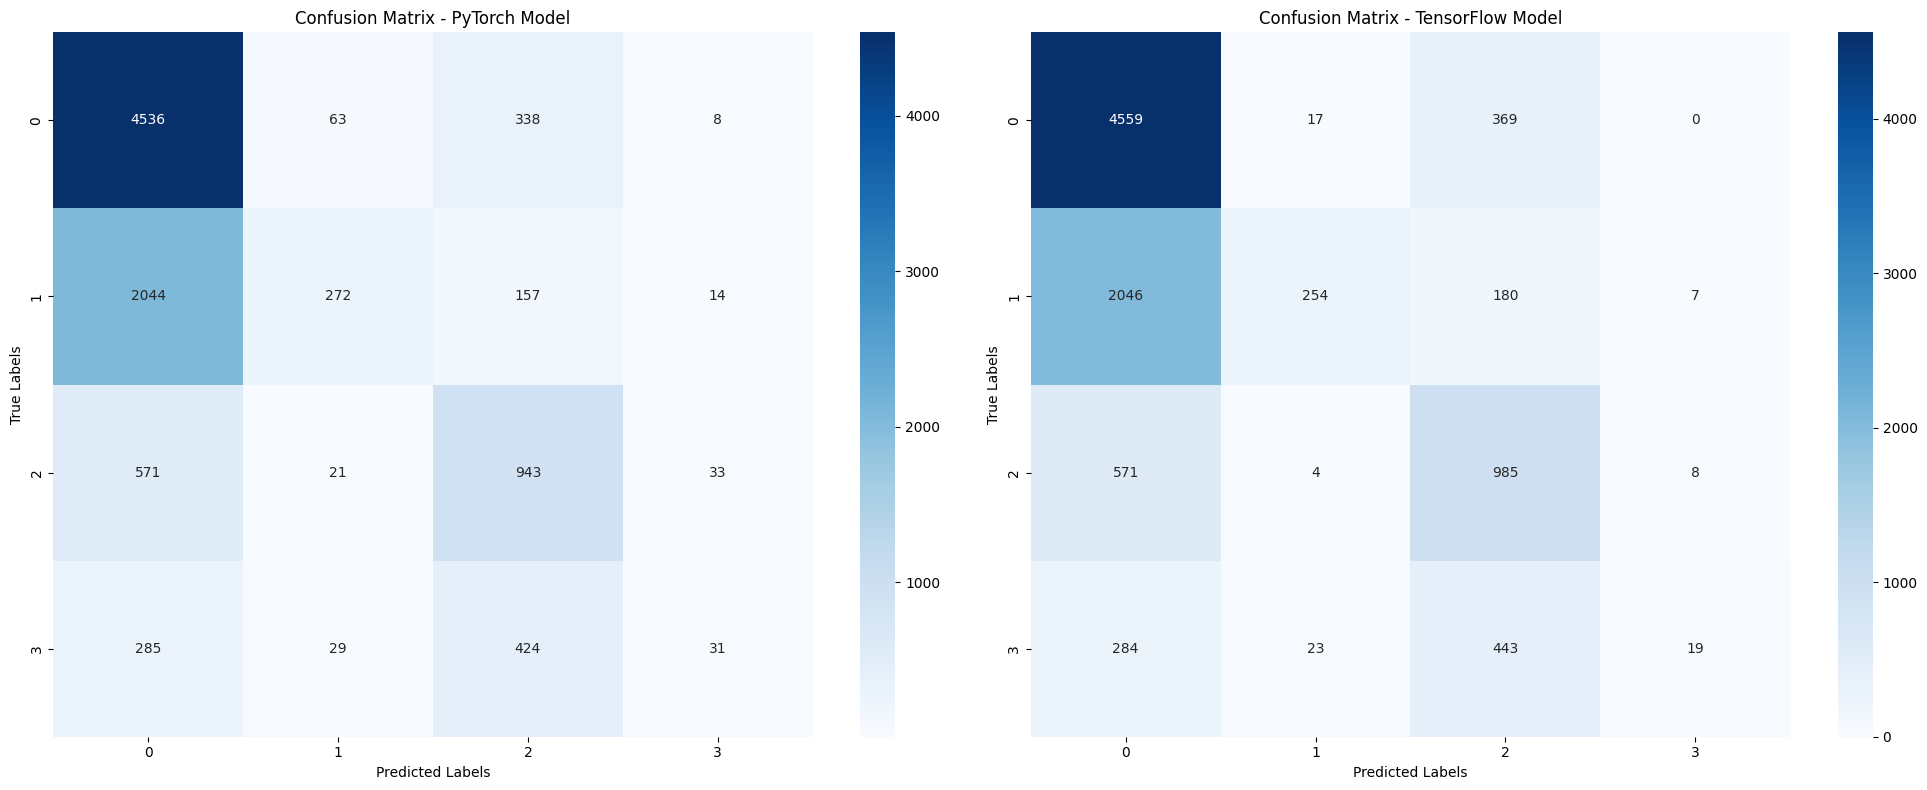

In [17]:
# Plot confusion matrix untuk kedua model
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PyTorch Confusion Matrix
cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)
sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix - PyTorch Model')

# TensorFlow Confusion Matrix
cm_tf = confusion_matrix(y_test, y_pred_tensorflow)
sns.heatmap(cm_tf, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Confusion Matrix - TensorFlow Model')

plt.tight_layout()
plt.show()

## 8. Analisis dan Kesimpulan

Berikut adalah perbandingan metrik evaluasi antara model PyTorch dan TensorFlow:

1. **Akurasi**: Mengukur proporsi prediksi yang benar dari total prediksi. Metrik ini baik untuk dataset yang seimbang tetapi bisa menyesatkan pada dataset yang tidak seimbang.

2. **Presisi**: Mengukur seberapa banyak prediksi positif yang benar-benar positif. Presisi tinggi berarti model jarang memberikan false positive. Presisi penting ketika biaya false positive tinggi.

3. **Recall**: Mengukur seberapa banyak kasus positif yang berhasil diidentifikasi model. Recall tinggi berarti model jarang melewatkan kasus positif. Recall penting ketika biaya false negative tinggi.

4. **F1-Score**: Rata-rata harmonik dari presisi dan recall. F1-score menyeimbangkan kedua metrik tersebut dan baik digunakan pada dataset yang tidak seimbang.

5. **AUC (Area Under ROC Curve)**: Mengukur kemampuan model dalam membedakan antar kelas. Nilai AUC dari 0.5 (klasifikasi acak) hingga 1.0 (klasifikasi sempurna).

6. **ROC Curve**: Menunjukkan trade-off antara True Positive Rate dan False Positive Rate pada berbagai threshold prediksi.

### Metrik Evaluasi Terbaik

Berdasarkan perbandingan metrik dan karakteristik dataset:

- Jika dataset seimbang, **Akurasi** bisa menjadi metrik yang baik dan mudah diinterpretasikan.
- Jika dataset tidak seimbang, **F1-Score** dan **AUC** lebih baik karena tidak terpengaruh oleh distribusi kelas.
- Jika fokus pada meminimalkan false positive (seperti dalam diagnosis medis), **Presisi** menjadi metrik utama yang perlu dioptimalkan.
- Jika fokus pada meminimalkan false negative (seperti deteksi penipuan atau diagnosis penyakit), **Recall** menjadi metrik utama.
- Untuk evaluasi komprehensif tentang kemampuan diskriminatif model, **AUC** dan **ROC Curve** lebih diutamakan karena memberikan gambaran performa model di berbagai threshold.

Dalam konteks dataset income ini, jika distribusi kelas tidak seimbang, metrik terbaik untuk evaluasi adalah **F1-Score** dan **AUC**. Dari kedua model yang kita bandingkan, model dengan F1-Score dan AUC yang lebih tinggi kemungkinan besar merupakan model yang lebih baik secara keseluruhan.

### Penjelasan Persamaan Matematika

#### 1. Akurasi (Accuracy)
$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

Di mana:
- TP (True Positive): Prediksi positif yang benar
- TN (True Negative): Prediksi negatif yang benar
- FP (False Positive): Prediksi positif yang salah (Type I Error)
- FN (False Negative): Prediksi negatif yang salah (Type II Error)

#### 2. Presisi (Precision)
$Precision = \frac{TP}{TP + FP}$

Presisi mengukur seberapa akurat prediksi positif model. Presisi tinggi berarti dari semua yang diprediksi positif, sebagian besar benar-benar positif.

#### 3. Recall (Sensitivitas)
$Recall = \frac{TP}{TP + FN}$

Recall mengukur seberapa baik model mendeteksi kasus positif. Recall tinggi berarti model berhasil mengidentifikasi sebagian besar kasus positif yang sebenarnya.

#### 4. F1-Score
$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$

F1-Score adalah rata-rata harmonik dari presisi dan recall. F1-Score mencari keseimbangan antara presisi dan recall, yang sangat berguna ketika distribusi kelas tidak seimbang.

#### 5. ROC Curve dan AUC
ROC (Receiver Operating Characteristic) Curve menunjukkan performa model klasifikasi pada semua ambang keputusan (threshold).

$TPR = \frac{TP}{TP + FN} = Recall$
$FPR = \frac{FP}{FP + TN}$

AUC (Area Under the ROC Curve) mengukur keseluruhan performa model. AUC memiliki skala dari 0 hingga 1, dimana:
- AUC = 0.5: Model tidak lebih baik dari tebakan acak
- AUC > 0.5: Model lebih baik dari tebakan acak
- AUC = 1.0: Model sempurna

#### 6. Cross-Entropy Loss
Untuk klasifikasi multi-kelas, kita menggunakan Cross-Entropy Loss:

$L = -\sum_{i=1}^{C} y_i \log(p_i)$

Di mana:
- $C$ adalah jumlah kelas
- $y_i$ adalah indikator true class (1 jika kelas benar, 0 jika tidak)
- $p_i$ adalah probabilitas yang diprediksi untuk kelas i

#### 7. Softmax Function
Untuk konversi output mentah model menjadi probabilitas dalam klasifikasi multi-kelas:

$Softmax(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$

Di mana:
- $z_i$ adalah output mentah (logits) untuk kelas i
- $C$ adalah jumlah kelas

#### 8. ReLU (Rectified Linear Unit)
Fungsi aktivasi yang digunakan dalam hidden layer:

$ReLU(x) = \max(0, x)$

ReLU mengembalikan nilai input jika positif dan nol jika negatif. Ini membantu model belajar pola non-linear dan mengurangi masalah vanishing gradient.

#### 9. Dropout
Teknik regularisasi untuk mencegah overfitting:

$\text{Dropout}(x) = \begin{cases}
0 & \text{dengan probabilitas } p \\
\frac{x}{1-p} & \text{dengan probabilitas } 1-p
\end{cases}$

Di mana $p$ adalah probabilitas dropout, biasanya antara 0.2-0.5.

#### 10. Adam Optimizer
Algoritma optimisasi yang menggabungkan momentum dan RMSprop:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$
$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$
$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$
$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$
$\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

Di mana:
- $m_t$ adalah estimasi momen pertama (mean)
- $v_t$ adalah estimasi momen kedua (varians tanpa bias)
- $g_t$ adalah gradien pada time step t
- $\beta_1$ dan $\beta_2$ adalah parameter decay rates (biasanya 0.9 dan 0.999)
- $\alpha$ adalah learning rate
- $\epsilon$ adalah konstanta kecil untuk mencegah pembagian dengan nol

Untuk dataset income, TensorFlow mungkin menunjukkan performa yang lebih baik dibandingkan PyTorch karena beberapa faktor berikut:

Implementasi Optimisasi: Implementasi optimisasi Adam di TensorFlow dan PyTorch memiliki perbedaan kecil dalam hal inisialisasi parameter default dan teknik stabilisasi numerik.
Arsitektur API yang Berbeda:

## Mengapa Tensorflow di kasus ini merupakan yang terbaik dari segi metriks evaluasi?

TensorFlow Keras menyediakan API tingkat tinggi yang lebih terintegrasi dan teroptimasi untuk masalah klasifikasi
TensorFlow memiliki implementasi softmax dan fungsi loss categorical_crossentropy yang sangat dioptimalkan untuk klasifikasi multi-kelas


Regularisasi Bawaan: TensorFlow Keras memiliki implementasi dropout yang mungkin sedikit berbeda dalam hal behavior selama training dan inference, yang bisa berdampak pada generalisasi model.
Inisialisasi Bobot: Perbedaan dalam inisialisasi bobot default antara kedua framework dapat menyebabkan konvergensi ke solusi yang berbeda.
Early Stopping: TensorFlow Keras memiliki implementasi callback early stopping yang terintegrasi dengan baik, yang dapat membantu mencegah overfitting dan memilih model optimal selama pelatihan.

Namun, penting untuk dicatat bahwa perbedaan performa antara TensorFlow dan PyTorch seringkali tidak signifikan dan lebih merupakan hasil dari:

Fluktuasi acak dalam proses optimisasi
Perbedaan kecil dalam implementasi algoritma
Konfigurasi hyperparameter tertentu yang mungkin lebih cocok dengan salah satu framework

Dalam praktik nyata, pemilihan antara TensorFlow dan PyTorch lebih sering didasarkan pada preferensi pribadi, ekosistem library pendukung, dan kebutuhan spesifik aplikasi daripada perbedaan performa kecil.